In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [2]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865 entries, 0 to 864
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               865 non-null    object 
 1   SeasonNumber       865 non-null    int64  
 2   SeasonVersion      865 non-null    int64  
 3   Player             865 non-null    object 
 4   MatchId            865 non-null    object 
 5   Map                865 non-null    object 
 6   Category           865 non-null    object 
 7   Playlist           865 non-null    object 
 8   Input              865 non-null    object 
 9   Queue              865 non-null    object 
 10  PreCsr             865 non-null    int64  
 11  PostCsr            865 non-null    int64  
 12  Rank               865 non-null    int64  
 13  WasAtStart         865 non-null    int64  
 14  WasAtEnd           865 non-null    int64  
 15  WasInProgressJoin  865 non-null    int64  
 16  Mmr                2 non-n

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['Damage/Kill'] = df['DamageDone'] / df['Kills']
# Per 10 Min
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['Shots/10Min'] = (df['ShotsFired'] / df['LengthMinutes']) * 10
# Excess
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
# Kill Type
df['BodyPct'] = df['KillsBody'] / df['Kills'] *100
df['MeleePct'] = df['KillsMelee'] / df['Kills'] * 100
df['HSPct'] = df['KillsHeadshot'] / df['Kills'] * 100
df['GrenadePct'] = df['KillsGrenade'] / df['Kills'] * 100
df['PowerPct'] = df['KillsPower'] / df['Kills'] * 100



df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'PreCsr', 'PostCsr', 'ShotsFired', 'AssistsEmp',
              'ShotsMissed', 'ShotsLanded', 'Betrayals', 'Suicides', 'WasAtStart', 'WasAtEnd', 'AssistsDriver',
              'Perfects', 'WasInProgressJoin', 'VehicleDestroys', 'VehicleHijacks', 'AssistsCallout',
              'LengthSeconds', 'Rank', 'SeasonNumber', 'SeasonVersion', 'Map'],axis=1)
df = df.drop(['KillsBody','KillsMelee', 'KillsGrenade', 'KillsHeadshot', 'KillsPower'], axis=1)
df = df.drop(['Kills','Deaths', 'Assists', 'DamageDone', 'DamageTaken'], axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfRR = dfR[dfR['Date']> '2023-01-01']
dfRR = dfRR[dfRR['Outcome'] != 'Draw']
dfRR = dfRR[dfRR['Outcome'] != 'Left']
dfRR['Outcome'] = dfRR['Outcome'].map({'Win': 1, 'Loss': 0})
dfRR = dfRR.drop(['Date', 'Category', 'Playlist'], axis=1)
dfRR = dfRR.dropna()
dfRR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603 entries, 140 to 864
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Outcome         603 non-null    int64  
 1   Accuracy        603 non-null    float64
 2   KD              603 non-null    float64
 3   KDA             603 non-null    float64
 4   MaxSpree        603 non-null    int64  
 5   ExpectedKills   603 non-null    float64
 6   ExpectedDeaths  603 non-null    float64
 7   Score           603 non-null    int64  
 8   Medals          603 non-null    int64  
 9   LengthMinutes   603 non-null    float64
 10  DamageRatio     603 non-null    float64
 11  Damage/Kill     603 non-null    float64
 12  Kills/10Min     603 non-null    float64
 13  Deaths/10Min    603 non-null    float64
 14  Assists/10Min   603 non-null    float64
 15  Dmg/10Min       603 non-null    float64
 16  DmgT/10Min      603 non-null    float64
 17  Shots/10Min     603 non-null    f

In [4]:
def cnt(df, col):
    count = df[col].count()
    return count
def sm(df, col):
    sum = df[col].sum()
    return sum
def avg(df, col, val=None):
    avg = round(sm(df, col) / cnt(df, col),val)
    return avg


In [5]:
corr_mtrx = dfRR.corr().abs()
print(corr_mtrx['Outcome'].sort_values(ascending=False))

Outcome           1.000000
Deaths/10Min      0.434589
DmgT/10Min        0.360040
KD                0.311987
KDA               0.282454
ExcessDeaths      0.263059
ExpectedDeaths    0.203392
Assists/10Min     0.186578
Damage/Kill       0.178586
Kills/10Min       0.142904
LengthMinutes     0.133443
DamageRatio       0.125850
MaxSpree          0.112415
Accuracy          0.105344
BodyPct           0.054293
HSPct             0.050378
Dmg/10Min         0.040131
Score             0.035752
ExpectedKills     0.032542
GrenadePct        0.021483
Medals            0.018892
MeleePct          0.015507
PowerPct          0.005506
ExcessKills       0.005401
Shots/10Min       0.002573
Name: Outcome, dtype: float64


In [6]:
# dfRR.hist(bins=15, figsize=(16, 12))
# plt.tight_layout()
# plt.show()

In [7]:
dfRR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Outcome,603.0,0.552239,0.497676,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,603.0,51.978060,5.230977,36.800000,48.610000,52.080000,55.025000,80.560000
KD,603.0,1.270697,0.750152,0.270000,0.860000,1.130000,1.450000,10.000000
KDA,603.0,4.567413,5.587118,-9.660000,0.660000,4.660000,8.000000,31.000000
MaxSpree,603.0,3.953566,1.557694,1.000000,3.000000,4.000000,5.000000,10.000000
ExpectedKills,603.0,14.567164,4.499175,2.000000,11.000000,14.000000,18.000000,32.000000
ExpectedDeaths,603.0,14.451078,4.647599,0.000000,11.000000,14.000000,17.000000,31.000000
Score,603.0,2150.514096,893.329601,250.000000,1450.000000,2035.000000,2700.000000,6625.000000
Medals,603.0,6.399668,3.694451,0.000000,4.000000,6.000000,8.000000,23.000000
LengthMinutes,603.0,10.525124,2.960653,1.483333,8.325000,9.983333,12.675000,21.333333


In [8]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [9]:
# Define features (X) and target variable (y)
X = dfRR.drop('Outcome', axis=1) 
X = round(X,20)
y = dfRR['Outcome'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (603, 24)
Y Shape: (603,)


In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=2)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')
print(X_train.columns)
print(X_test.info())

X Train Shape: (482, 24)
X Test Shape: (121, 24)
Index(['Accuracy', 'KD', 'KDA', 'MaxSpree', 'ExpectedKills', 'ExpectedDeaths',
       'Score', 'Medals', 'LengthMinutes', 'DamageRatio', 'Damage/Kill',
       'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min',
       'DmgT/10Min', 'Shots/10Min', 'ExcessKills', 'ExcessDeaths', 'BodyPct',
       'MeleePct', 'HSPct', 'GrenadePct', 'PowerPct'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 489 to 823
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Accuracy        121 non-null    float64
 1   KD              121 non-null    float64
 2   KDA             121 non-null    float64
 3   MaxSpree        121 non-null    int64  
 4   ExpectedKills   121 non-null    float64
 5   ExpectedDeaths  121 non-null    float64
 6   Score           121 non-null    int64  
 7   Medals          121 non-null    int64  
 8   LengthMinutes 

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Accuracy', 'ExpectedKills', 'ExpectedDeaths', 'KD', 'KDA', 'MaxSpree',
                                    # 'Deaths', 'Assists', 'Kills', 'DamageDone', 'DamageTaken',
                                    'Score', 'Medals', 'LengthMinutes', 'DamageRatio', 'Damage/Kill',
                                    'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min',
                                    'DmgT/10Min', 'Shots/10Min', 'ExcessKills', 'ExcessDeaths',
                                    'BodyPct', 'MeleePct', 'HSPct', 'GrenadePct', 'PowerPct'])])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

# X_train_preprocessed.to_csv('X_train_preprocessed.csv')
# X_test_preprocessed.to_csv('X_test_preprocessed.csv')

print(f'X Train Processed Shape: {X_train_preprocessed.shape}')
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Processed Shape: {X_test_preprocessed.shape}')

X Train Processed Shape: (482, 24)
X Train Shape: (482, 24)
X Test Processed Shape: (121, 24)


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, log_loss, classification_report, confusion_matrix
MSE_Histmean = mean_squared_error(y_test,np.full(y_test.shape,np.mean(y_train)))

def ResultsOut(model):
  y_pred = model.predict(X_test_preprocessed)
  # Calculate regression metrics
  acc = model.score(X_test_preprocessed, y_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)
  oosr2 = 1-mean_squared_error(y_test,y_pred)/MSE_Histmean
  ll = log_loss(y_test,y_pred)
  clRep = classification_report(y_test, y_pred)
  confM = confusion_matrix(y_test, y_pred)

  # Print the metrics with newline characters
  print("Acc: {:.3f}".format(acc))
  print("MAE: {:.2f}".format(mae))
  print("MSE: {:.2f}".format(mse))
  print("RMSE: {:.2f}".format(rmse))
  print("R^2 Score: {:.2f}".format(r2))
  print("OOS R^2 Score: {:.2f}".format(oosr2))
  print("Log Loss: {:.2f}".format(ll))
  print('---------------------------------------------------------')
  print(clRep)
  print('---------------------------------------------------------') 
  # print(confM)
  # print('---------------------------------------------------------') 
  return ''

def paramResults(mod):
    results_df = pd.DataFrame({'param': mod.cv_results_["params"], 'Accuracy': mod.cv_results_["mean_test_score"]})

    # Splitting the 'param' column into separate columns
    params_df = pd.DataFrame(results_df['param'].to_list())
    params_df.columns = [f"{col}_param" for col in params_df.columns]

    # Concatenating the new columns with the 'Accuracy' column
    results_df = pd.concat([params_df, results_df['Accuracy']], axis=1)

    # Displaying the updated DataFrame
    print(results_df)
    return ''

def featImport(mod):
    feat_importances = pd.DataFrame(mod.best_estimator_.feature_importances_[:24], index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances.plot(kind='bar', figsize=(8,6))
    plt.show()

def coefs(mod):
  # Get the coefficients
  coefficients = mod.coef_[0]

  # Create a dictionary with feature names and their corresponding coefficients
  feature_coefficients = dict(zip(X_train.columns, coefficients))

  # Sort features by coefficients in descending order
  sorted_features = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

  # Print or analyze the top 5 sorted feature coefficients
  print("Top 5 Sorted Feature Coefficients:")
  for feature, coefficient in sorted_features[:5]:
      print(f"{feature}: {coefficient:.2f}")


## Logistic Regression

In [13]:
# Unregularized Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(penalty=None)
logreg.fit(X_train_preprocessed, y_train)

print(f'Unregularized Logistic Regression Accuracy: {logreg.score(X_test_preprocessed, y_test)}')
print(ResultsOut(logreg))
print(coefs(logreg))

Unregularized Logistic Regression Accuracy: 0.7933884297520661
Acc: 0.793
MAE: 0.21
MSE: 0.21
RMSE: 0.45
R^2 Score: 0.15
OOS R^2 Score: 0.16
Log Loss: 7.45
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.80      0.77        51
           1       0.85      0.79      0.81        70

    accuracy                           0.79       121
   macro avg       0.79      0.79      0.79       121
weighted avg       0.80      0.79      0.79       121

---------------------------------------------------------

Top 5 Sorted Feature Coefficients:
DamageRatio: -4.87
KD: 3.39
Deaths/10Min: -3.24
DmgT/10Min: -2.86
Dmg/10Min: 2.68
None


## Ridge

In [14]:
# Ridge
# Need to find best params for param grid

C_grid = [10**-3,10**-2,10**-1,10**0,10**1,10**2]

param_grid={'C':C_grid}
ridge_cv = GridSearchCV(LogisticRegression(penalty='l2',solver='saga'),
                                          param_grid=param_grid,cv=5)
ridge_cv.fit(X_train_preprocessed,y_train)

print(ridge_cv.best_estimator_)
print(f'Ridge Accuracy: {ridge_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(ridge_cv))
print(ResultsOut(ridge_cv))
print(coefs(ridge_cv.best_estimator_))


LogisticRegression(C=10, solver='saga')
Ridge Accuracy: 0.8016528925619835
   C_param  Accuracy
0    0.001  0.663918
1    0.010  0.715700
2    0.100  0.776009
3    1.000  0.786383
4   10.000  0.788488
5  100.000  0.788488

Acc: 0.802
MAE: 0.20
MSE: 0.20
RMSE: 0.45
R^2 Score: 0.19
OOS R^2 Score: 0.19
Log Loss: 7.15
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        51
           1       0.85      0.80      0.82        70

    accuracy                           0.80       121
   macro avg       0.80      0.80      0.80       121
weighted avg       0.81      0.80      0.80       121

---------------------------------------------------------

Top 5 Sorted Feature Coefficients:
Deaths/10Min: -2.51
KD: 1.94
KDA: -1.74
ExcessKills: -1.72
ExcessDeaths: -1.66
None


## Lasso

In [15]:
# Lasso

param_grid={'C':C_grid}
lasso_cv = GridSearchCV(LogisticRegression(penalty='l1',solver='saga'),
                                          param_grid=param_grid,cv=5)
lasso_cv.fit(X_train_preprocessed,y_train)

print(lasso_cv.best_estimator_)
print(f'Lasso Accuracy: {lasso_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(lasso_cv))
print(ResultsOut(lasso_cv))
print(coefs(lasso_cv.best_estimator_))

LogisticRegression(C=10, penalty='l1', solver='saga')
Lasso Accuracy: 0.8016528925619835
   C_param  Accuracy
0    0.001  0.545640
1    0.010  0.545640
2    0.100  0.717805
3    1.000  0.788466
4   10.000  0.790550
5  100.000  0.788488

Acc: 0.802
MAE: 0.20
MSE: 0.20
RMSE: 0.45
R^2 Score: 0.19
OOS R^2 Score: 0.19
Log Loss: 7.15
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        51
           1       0.85      0.80      0.82        70

    accuracy                           0.80       121
   macro avg       0.80      0.80      0.80       121
weighted avg       0.81      0.80      0.80       121

---------------------------------------------------------

Top 5 Sorted Feature Coefficients:
Deaths/10Min: -2.55
KD: 1.96
KDA: -1.76
ExcessKills: -1.72
ExcessDeaths: -1.68
None


## ElasticNet

In [16]:
# ElasticNet

param_grid2={'C':C_grid,'l1_ratio':[.25, .5, .75]}

elastic_cv = GridSearchCV(LogisticRegression(penalty='elasticnet',solver='saga'),
                                            param_grid=param_grid2,cv=5)
elastic_cv.fit(X_train_preprocessed,y_train)

print(elastic_cv.best_estimator_)
print(f'ElasticNet Accuracy: {elastic_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(elastic_cv))
print(ResultsOut(elastic_cv))
print(coefs(elastic_cv.best_estimator_))



LogisticRegression(C=10, l1_ratio=0.75, penalty='elasticnet', solver='saga')
ElasticNet Accuracy: 0.8016528925619835
    C_param  l1_ratio_param  Accuracy
0     0.001            0.25  0.545640
1     0.001            0.50  0.545640
2     0.001            0.75  0.545640
3     0.010            0.25  0.707345
4     0.010            0.50  0.651310
5     0.010            0.75  0.553909
6     0.100            0.25  0.763509
7     0.100            0.50  0.744824
8     0.100            0.75  0.730284
9     1.000            0.25  0.784300
10    1.000            0.50  0.782238
11    1.000            0.75  0.786383
12   10.000            0.25  0.788488
13   10.000            0.50  0.788488
14   10.000            0.75  0.790550
15  100.000            0.25  0.788488
16  100.000            0.50  0.788488
17  100.000            0.75  0.788488

Acc: 0.802
MAE: 0.20
MSE: 0.20
RMSE: 0.45
R^2 Score: 0.19
OOS R^2 Score: 0.19
Log Loss: 7.15
---------------------------------------------------------
         

## K-Nearest Neighbours

In [17]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

k_values = list(range(1,50,3))
param_grid = {'n_neighbors': k_values}

knn_cv = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
knn_cv.fit(X_train_preprocessed,y_train)

print(knn_cv.best_estimator_)
print(f'K-Nearest Neighbors Accuracy: {knn_cv.score(X_test_preprocessed, y_test)}')
knn_cv.cv_results_
print(paramResults(knn_cv))
print(ResultsOut(knn_cv))



KNeighborsClassifier(n_neighbors=16)
K-Nearest Neighbors Accuracy: 0.6611570247933884
    n_neighbors_param  Accuracy
0                   1  0.614240
1                   4  0.651353
2                   7  0.678393
3                  10  0.692934
4                  13  0.684579
5                  16  0.699162
6                  19  0.684579
7                  22  0.682582
8                  25  0.688767
9                  28  0.682560
10                 31  0.680498
11                 34  0.672229
12                 37  0.672143
13                 40  0.672208
14                 43  0.676396
15                 46  0.661877
16                 49  0.674356

Acc: 0.661
MAE: 0.34
MSE: 0.34
RMSE: 0.58
R^2 Score: -0.39
OOS R^2 Score: -0.38
Log Loss: 12.21
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.59      0.59        51
           1       0.70      0.71      0.71        70

    accuracy       

## Random Forest

In [18]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'n_estimators': [100,300,500],'max_depth': [10, 15, 20]}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=69,max_features='sqrt'),
                                                     cv=5, param_grid=param_grid_rf,n_jobs=-1)
rf_cv.fit(X_train_preprocessed, y_train)

print(rf_cv.best_estimator_)
print(f'Random Forest Accuracy: {rf_cv.score(X_test_preprocessed, y_test)}')
rf_cv.cv_results_
paramResults(rf_cv)

RandomForestClassifier(max_depth=10, random_state=69)
Random Forest Accuracy: 0.6942148760330579
   max_depth_param  n_estimators_param  Accuracy
0               10                 100  0.711662
1               10                 300  0.701246
2               10                 500  0.701224
3               15                 100  0.695039
4               15                 300  0.703308
5               15                 500  0.705369
6               20                 100  0.690872
7               20                 300  0.703286
8               20                 500  0.703286


''

In [19]:
ResultsOut(rf_cv)

Acc: 0.694
MAE: 0.31
MSE: 0.31
RMSE: 0.55
R^2 Score: -0.25
OOS R^2 Score: -0.25
Log Loss: 11.02
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.63      0.63        51
           1       0.73      0.74      0.74        70

    accuracy                           0.69       121
   macro avg       0.69      0.69      0.69       121
weighted avg       0.69      0.69      0.69       121

---------------------------------------------------------


''

<AxesSubplot: >

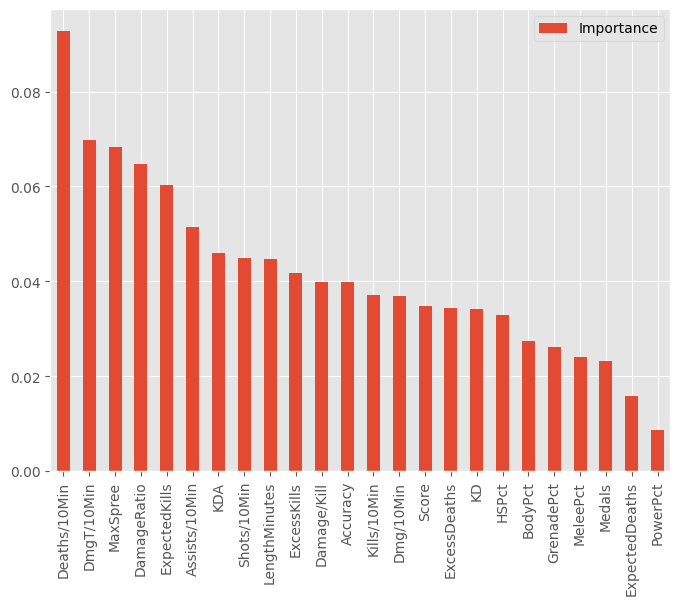

In [20]:
feat_importances = pd.DataFrame(rf_cv.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Gradient Boosted Trees

In [21]:
# Gradient Boosted Trees
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbrt = {'n_estimators': [100,300,500],'learning_rate': [0.01,0.1],'max_depth': [2,4,6], 'subsample': [0.5,0.6,0.8,1]}
GBRT = GridSearchCV(estimator=GradientBoostingClassifier(random_state=69),
                    cv=5, param_grid=param_grid_gbrt,n_jobs=-1)
GBRT.fit(X_train_preprocessed, y_train)

print(GBRT.best_estimator_)
print(f'Gradient Boosed Trees Accuracy: {GBRT.score(X_test_preprocessed, y_test)}')
GBRT.cv_results_
paramResults(GBRT)

GradientBoostingClassifier(max_depth=6, n_estimators=300, random_state=69,
                           subsample=0.8)
Gradient Boosed Trees Accuracy: 0.7272727272727273
    learning_rate_param  max_depth_param  n_estimators_param  subsample_param  \
0                  0.01                2                 100              0.5   
1                  0.01                2                 100              0.6   
2                  0.01                2                 100              0.8   
3                  0.01                2                 100              1.0   
4                  0.01                2                 300              0.5   
..                  ...              ...                 ...              ...   
67                 0.10                6                 300              1.0   
68                 0.10                6                 500              0.5   
69                 0.10                6                 500              0.6   
70                 0.1

''

In [22]:
ResultsOut(GBRT)

Acc: 0.727
MAE: 0.27
MSE: 0.27
RMSE: 0.52
R^2 Score: -0.12
OOS R^2 Score: -0.11
Log Loss: 9.83
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.69      0.68        51
           1       0.77      0.76      0.76        70

    accuracy                           0.73       121
   macro avg       0.72      0.72      0.72       121
weighted avg       0.73      0.73      0.73       121

---------------------------------------------------------


''

<AxesSubplot: >

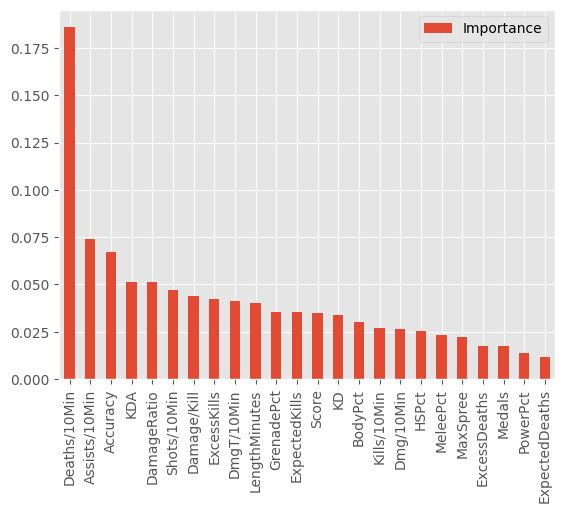

In [23]:
feat_importances = pd.DataFrame(GBRT.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

## XGBoost

In [24]:
from xgboost import XGBClassifier

param_grid_xgb = {'n_estimators': [400,450,475,500],'learning_rate': [0.001,0.01,0.1,0.25],'max_depth': [1,2,3,4,5]}
XGB = GridSearchCV(estimator=XGBClassifier(random_state=69), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
XGB.fit(X_train_preprocessed, y_train)

print(XGB.best_estimator_)
print(f'XGBoost Accuracy: {XGB.score(X_test_preprocessed, y_test)}')
paramResults(XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=69, ...)
XGBoost Accuracy: 0.7024793388429752
    learning_rate_param  max_depth_param  n_estimators_param  Accuracy
0                 0.001                1                 400  0.690808
1                 0.001                1                 450  0.699141
2  

''

In [25]:
ResultsOut(XGB)

Acc: 0.702
MAE: 0.30
MSE: 0.30
RMSE: 0.55
R^2 Score: -0.22
OOS R^2 Score: -0.21
Log Loss: 10.72
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.65      0.65        51
           1       0.74      0.74      0.74        70

    accuracy                           0.70       121
   macro avg       0.69      0.69      0.69       121
weighted avg       0.70      0.70      0.70       121

---------------------------------------------------------


''

<AxesSubplot: >

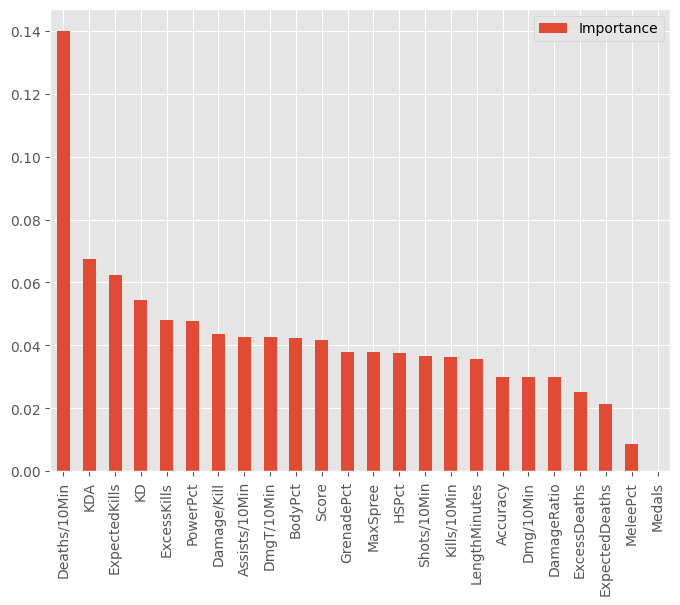

In [26]:
feat_importances = pd.DataFrame(XGB.best_estimator_.feature_importances_[:32], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Neural Net

In [27]:
from sklearn.neural_network import MLPClassifier

param_grid_nn = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'],
                'learning_rate': ['constant', 'invscaling', 'adaptive'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
nn = GridSearchCV(estimator=MLPClassifier(random_state=61), cv=5, param_grid=param_grid_nn, n_jobs=-1)

nn.fit(X_train_preprocessed, y_train)
print(nn)
print(f'Neural Net Accuracy: {nn.score(X_test_preprocessed, y_test)}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=61), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'solver': ['lbfgs', 'sgd', 'adam']})
Neural Net Accuracy: 0.7933884297520661


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

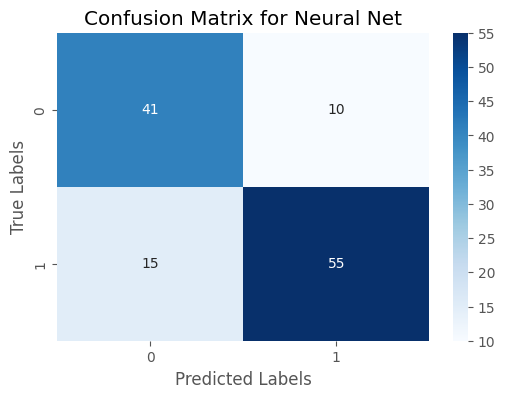

The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.


<AxesSubplot: >

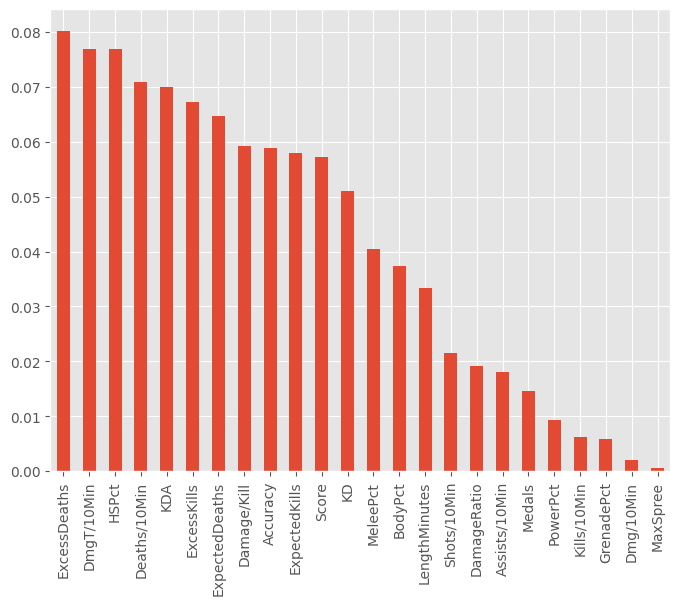

In [28]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix for the Neural Net
conf_matrix = confusion_matrix(y_test, nn.predict(X_test_preprocessed))
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Neural Net')
plt.show()

print("The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.")
feat_importances_nn = pd.DataFrame(nn.best_estimator_.coefs_[0].flatten()[:24], index=X_train.columns, columns=["Importance"])
feat_importances_nn = feat_importances_nn.abs().sum(axis=1)
feat_importances_nn = feat_importances_nn / feat_importances_nn.sum()
feat_importances_nn = feat_importances_nn.sort_values(ascending=False)[:24]
feat_importances_nn.plot(kind='bar', figsize=(8,6))

,Model,ACC,MAE,MSE,RMSE,R2,OOS R2,Log Loss
0,Ridge,0.802,0.198,0.198,0.445,0.187,0.190,7.149
1,Lasso,0.802,0.198,0.198,0.445,0.187,0.190,7.149
2,ElasticNet,0.802,0.198,0.198,0.445,0.187,0.190,7.149
3,Logistic Regression,0.793,0.207,0.207,0.455,0.153,0.156,7.447
4,NeuralNet,0.793,0.207,0.207,0.455,0.153,0.156,7.447
5,Gradient Boosted Trees,0.727,0.273,0.273,0.522,-0.118,-0.114,9.830
6,XGBoost,0.702,0.298,0.298,0.545,-0.220,-0.215,10.724
7,Random Forest,0.694,0.306,0.306,0.553,-0.254,-0.249,11.022
8,K-Nearest Neighbors,0.661,0.339,0.339,0.582,-0.390,-0.384,12.213


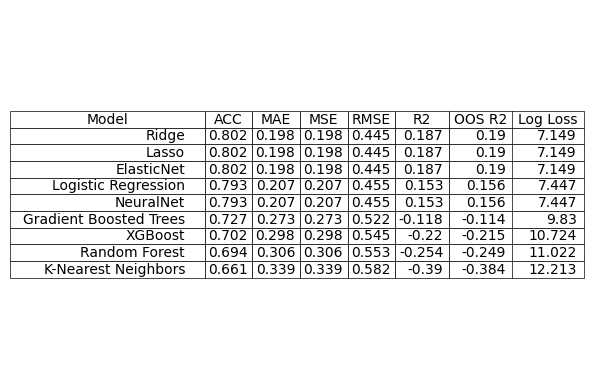

In [29]:
modelss = [logreg,ridge_cv,lasso_cv,elastic_cv,knn_cv,rf_cv,GBRT,XGB,nn]
model_namess = ['Logistic Regression', 'Ridge', 'Lasso', 'ElasticNet',
              'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosted Trees', 'XGBoost', 'NeuralNet']
def saveResults(models, model_names):
    # Initialize an empty dataframe to store the metrics
    metrics_df = pd.DataFrame(columns=['Model', 'ACC' ,'MAE', 'MSE', 'RMSE', 'R2', 'OOS R2', 'Log Loss'])
    
    # Loop through each model and calculate the metrics
    for i, model in enumerate(models):
        # Generate predictions on the test set
        y_pred = model.predict(X_test_preprocessed)
        
        # Calculate regression metrics
        acc = round(model.score(X_test_preprocessed, y_test),3)
        mae = round(mean_absolute_error(y_test, y_pred),3)
        mse = round(mean_squared_error(y_test, y_pred),3)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False),3)
        r2 = round(r2_score(y_test, y_pred),3)
        oosr2 = round(1-mean_squared_error(y_test,y_pred)/MSE_Histmean,3)
        ll = round(log_loss(y_test,y_pred),3)
        
        # Add metrics to the dataframe
        metrics_df.loc[i] = [model_names[i],acc, mae, mse, rmse, r2, oosr2, ll]
    
    metrics_df = metrics_df.sort_values('ACC', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots()
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                     cellLoc='right', loc='center')
    table.auto_set_font_size(True)
    table.auto_set_column_width(col=list(range(len(metrics_df.columns))))
    ax.axis('off')
    plt.savefig('ModelResults0210.png', dpi=300, bbox_inches='tight')
    
    return metrics_df

saveResults(modelss,model_namess)


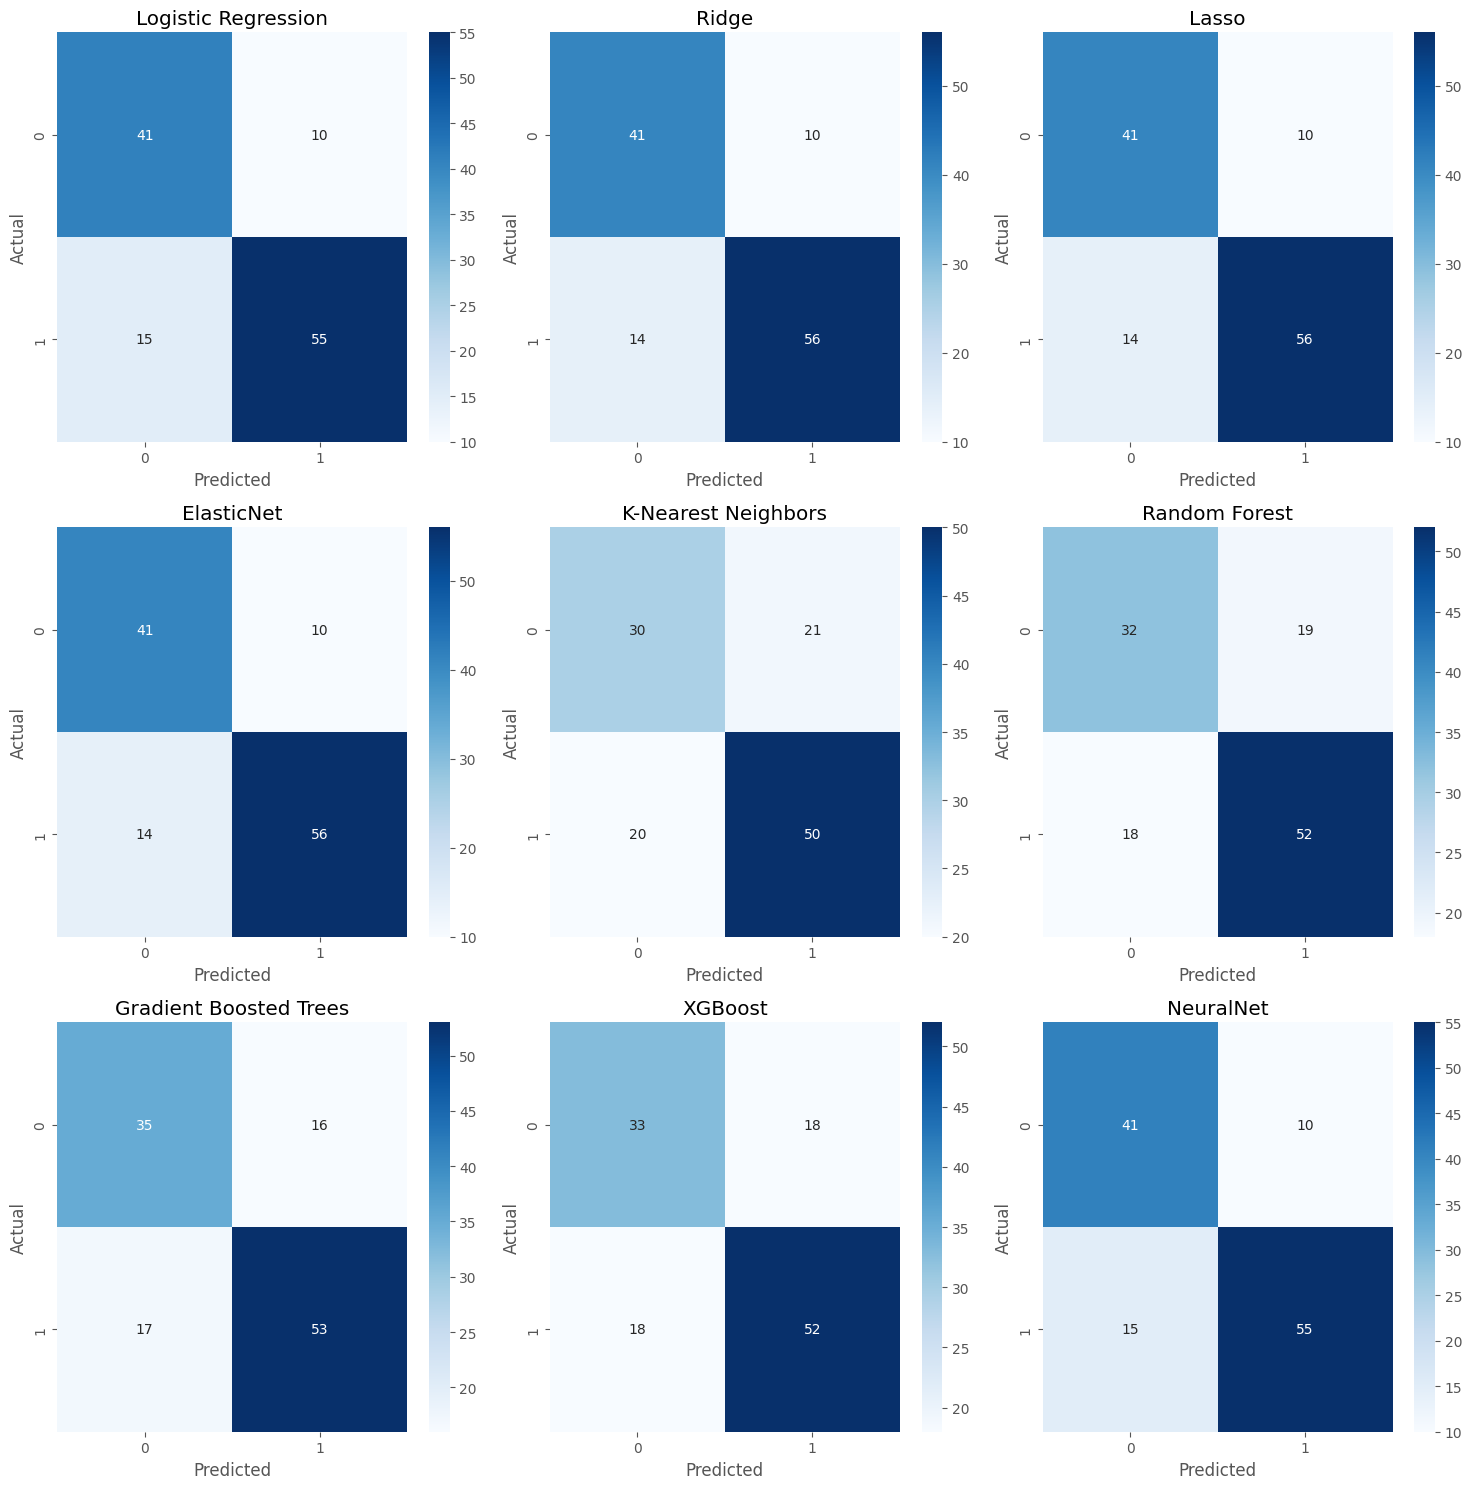

In [30]:
# Assuming X_test_preprocessed and y_test are your test data
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, (model, model_name) in enumerate(zip(modelss, model_namess)):
    y_pred = model.predict(X_test_preprocessed)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(model_name)
    axs[i//3, i%3].set_xlabel('Predicted')
    axs[i//3, i%3].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('Plots/ConfusionMatrixMultigraph.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
print(f'Runtime: {round(time.perf_counter() - start,2)}s')

Runtime: 77.08s


In [32]:
X_trainp_df = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)
round(X_trainp_df.describe().transpose(),3).sort_values(by='max',ascending=False)

,count,mean,std,min,25%,50%,75%,max
MaxSpree,482.0,0.0,1.001,-1.274,-0.558,-0.199,0.249,11.176
DamageRatio,482.0,0.0,1.001,-1.767,-0.640,-0.106,0.445,10.414
Damage/Kill,482.0,0.0,1.001,-1.963,-0.662,-0.213,0.416,6.562
Shots/10Min,482.0,0.0,1.001,-3.007,-0.609,0.002,0.578,6.028
PowerPct,482.0,0.0,1.001,-0.378,-0.378,-0.378,-0.378,5.626
Medals,482.0,0.0,1.001,-1.717,-0.831,-0.081,0.464,4.554
ExpectedDeaths,482.0,-0.0,1.001,-1.899,-0.582,0.077,0.735,4.028
KD,482.0,0.0,1.001,-2.610,-0.807,-0.131,0.714,3.925
MeleePct,482.0,0.0,1.001,-1.195,-1.195,-0.050,0.605,3.844
LengthMinutes,482.0,-0.0,1.001,-2.674,-0.750,-0.183,0.722,3.719
